Specify the directory of the surprise storm on google drive.

In [29]:
# folder_path = '/content/drive/My Drive/surprise_storm'
folder_path = './surprise_storm'

Specify the filepath of saved models.

In [30]:
# model_filepath=['','/content/drive/My Drive/CNNmodel256.pth']
model_filepath=['','./CNNmodel256.pth']

In [ ]:
from google.colab import drive

drive.mount('/content/drive')  # mount Google Drive

In [31]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from Task2 import read_test_data, CNNRegression, train, evaluate

In [32]:
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Future image generation

## Wind speed prediction

In [97]:
cnn_model = CNNRegression()  # initialize the CNN model
state_dict = torch.load(model_filepath[1], map_location=torch.device('cpu'))
cnn_model.load_state_dict(state_dict)

<All keys matched successfully>

In [108]:
storm_ids, images, features, wind_labels = read_test_data(filepath=folder_path, image_size=256)   # read surprise storm data

Retrain the model on the surprise storm excluding the last 13 images.

In [109]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images[:-13], wind_labels, test_size=0.2, random_state=42)

X_train = X_train.reshape(-1, 1, 256, 256)
X_test = X_test.reshape(-1, 1, 256, 256)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [100]:
train(cnn_model, train_loader, lr=0.001, num_epochs=10)

Epoch 1/10, Loss: 274.4535217285156
Epoch 2/10, Loss: 18.492979049682617
Epoch 3/10, Loss: 25.63006591796875
Epoch 4/10, Loss: 24.8034725189209
Epoch 5/10, Loss: 36.645751953125
Epoch 6/10, Loss: 6.374630928039551
Epoch 7/10, Loss: 32.57455825805664
Epoch 8/10, Loss: 8.544889450073242
Epoch 9/10, Loss: 6.451507568359375
Epoch 10/10, Loss: 4.2793731689453125


In [101]:
evaluate(cnn_model, val_loader)

Validation RMSE Loss: 3.2603560553105564


In [110]:
# unlabeled_images = images[-13:].reshape(-1, 1, 256, 256)
unlabeled_images = images.reshape(-1, 1, 256, 256)
img_tensor = torch.FloatTensor(unlabeled_images)

predictions = np.array([])
with torch.no_grad():
    predictions = cnn_model(img_tensor)
    
# wind_labels=np.hstack((wind_labels, predictions.view(-1).numpy()))  # append 13 predicted wind speeds

In [69]:
predictions = np.array([])
with torch.no_grad():
    predictions = cnn_model(img_tensor)
    
wind_labels=np.hstack((wind_labels, predictions.view(-1).numpy()[-13:]))  # append 13 predicted wind speeds

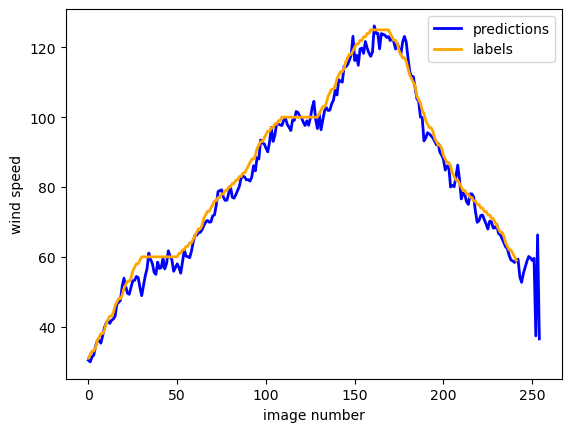

In [103]:
import matplotlib.pyplot as plt

plt.plot(predictions, color='blue', linewidth=2, label='predictions')
plt.plot(wind_labels, color='orange', linewidth=2, label='labels')
plt.xlabel('image number')
plt.ylabel('wind speed')
plt.legend()
plt.show()

In [111]:
wind_labels=np.hstack((wind_labels, predictions.view(-1).numpy()[-13:]))  # append 13 predicted wind speeds

Save the final output to csv file.

In [112]:
import pandas as pd

def output_csv(image_ids, features, wind_speed):
    """
    Generate a CSV file with storm predictions based on the provided data.

    Parameters:
    - image_ids (numpy.ndarray): Array of image IDs.
    - features (numpy.ndarray): 2D Array of feature vectors (containing relative time and ocean data).
    - wind_speed (numpy.ndarray): Array of wind speed predictions.

    Returns:
    - None: The function generates a CSV file and does not return any value."""

    storm_id = np.array([s[:3] for s in image_ids])
    relative_time, ocean = features[:,0], features[:,1]
    
    df = pd.DataFrame({'relative_time': relative_time, 'wind_speed': wind_speed.astype(int)})
    df.tail(13).to_csv('Nicholas_windpredictions.csv', index=False, header=False)
    return df.tail(13)
    
output_csv(storm_ids,features,wind_labels)

,relative_time,wind_speed
242,522000,59
243,523800,54
244,525601,52
245,529199,55
246,530999,57
247,532799,58
248,534599,60
249,536398,59
250,539999,58
251,541799,59
